In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import astropy as ast
from astropy import stats


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/ER4d_sytjGCaMP7f_attp2')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df['fly_id'] = [row['date']+'_'+row['fly'] for _, row in sess_df.iterrows()]

/tmp/ipykernel_675110/857575644.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax= plt.subplots()


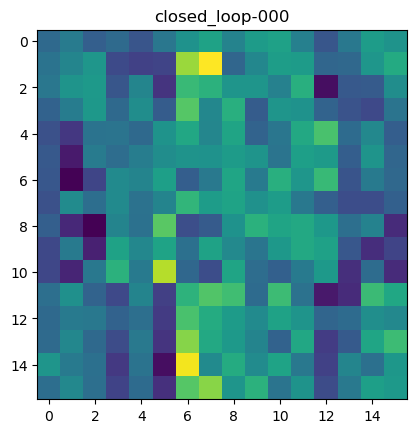

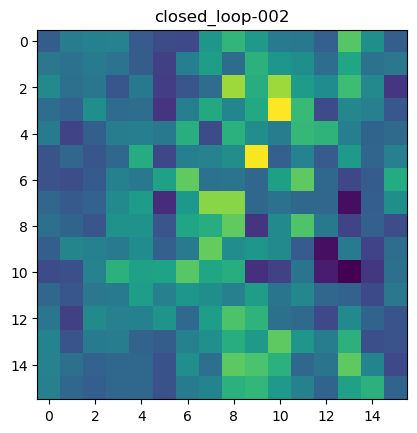

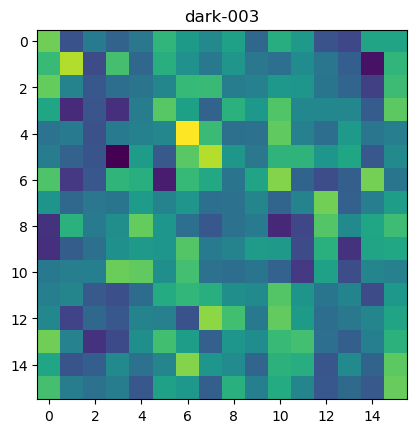

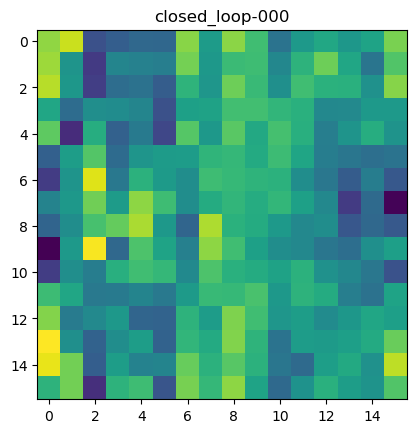

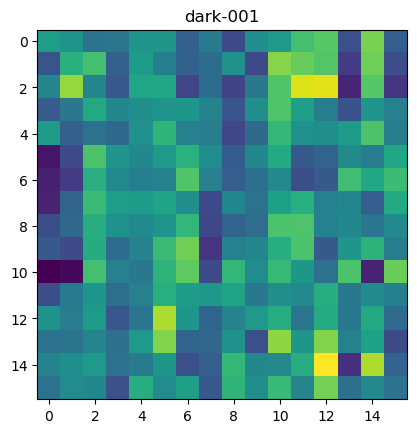

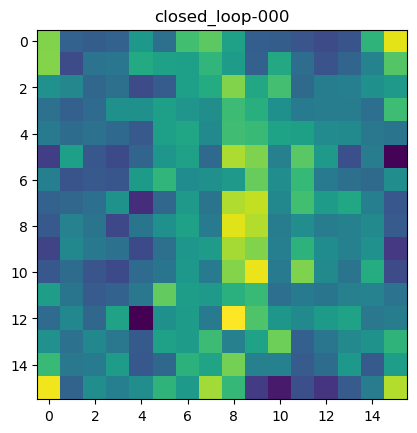

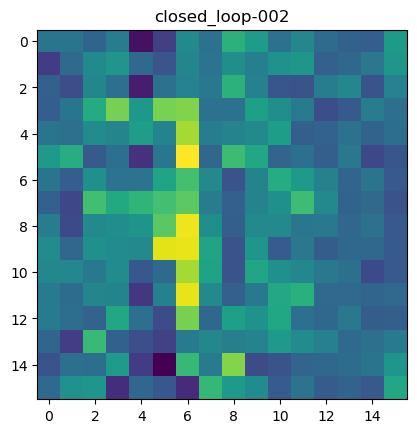

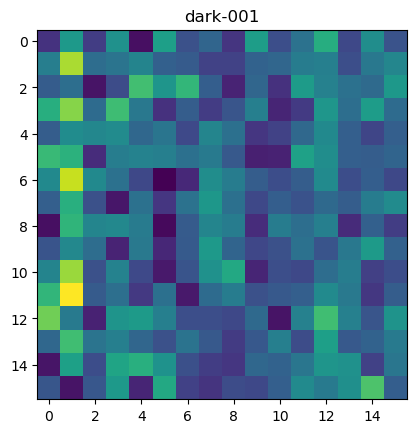

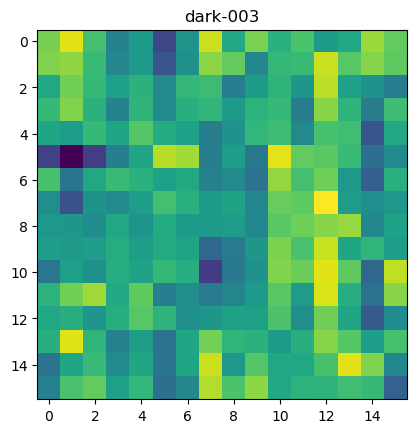

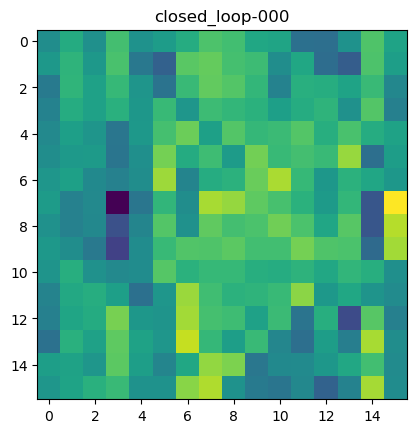

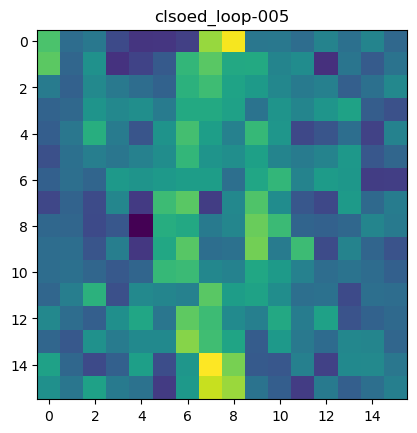

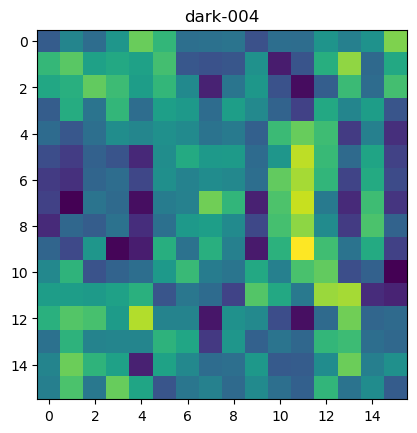

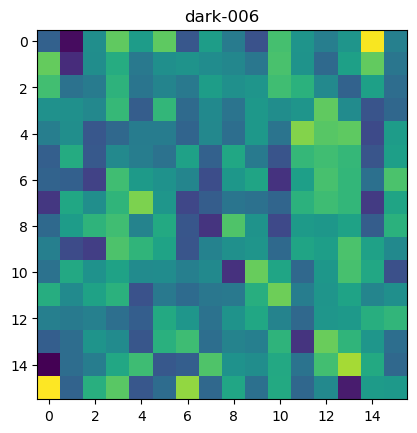

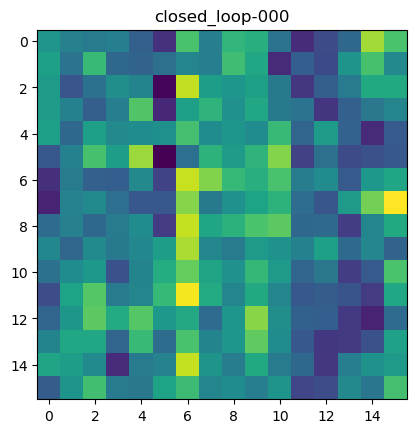

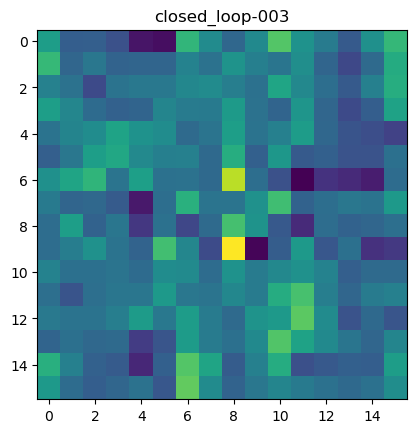

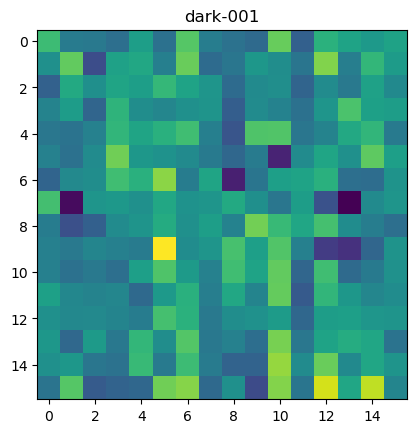

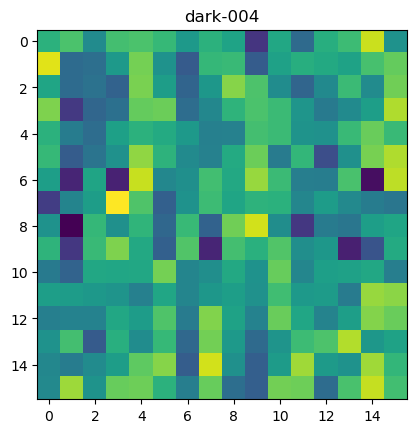

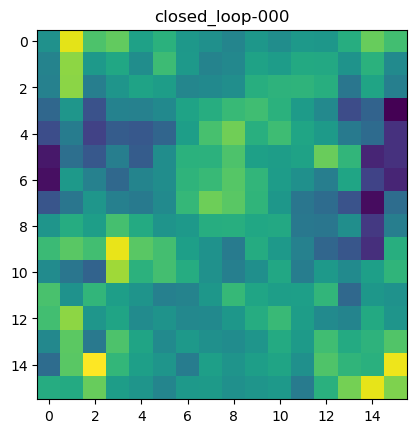

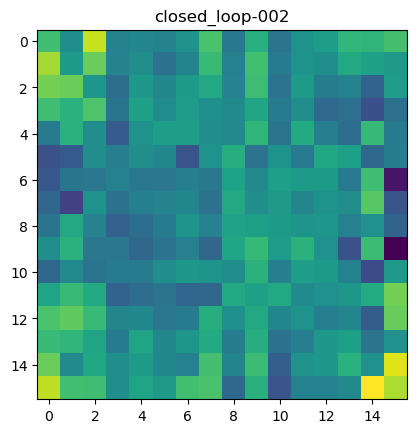

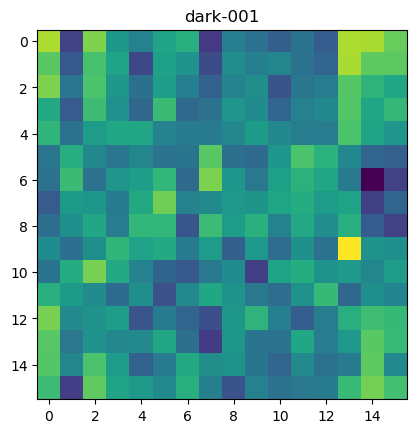

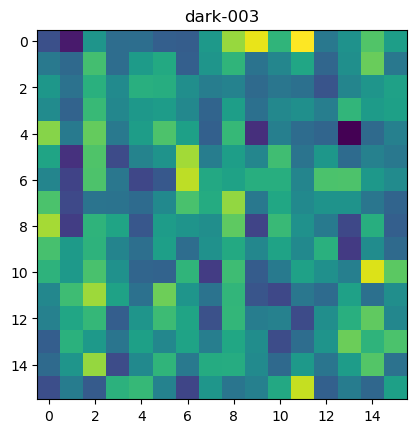

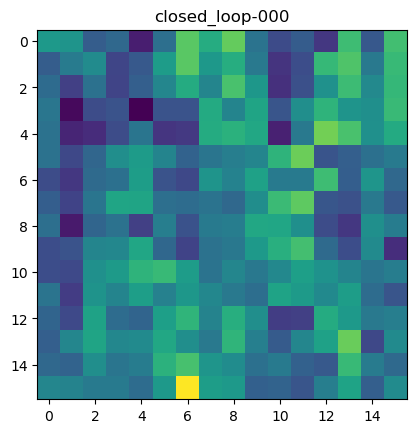

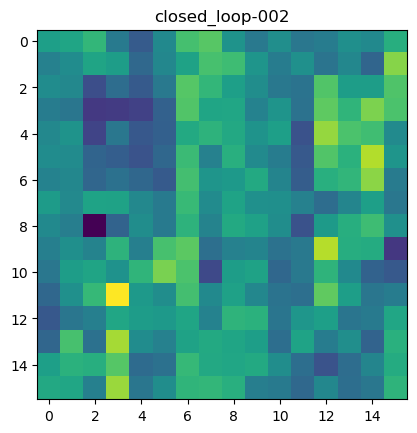

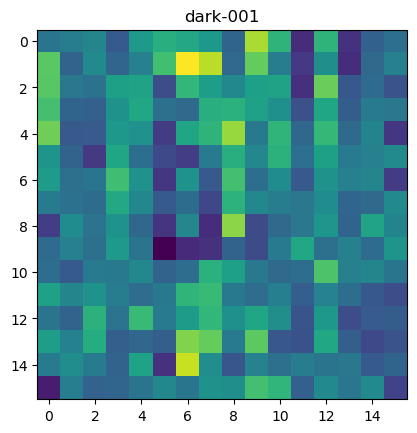

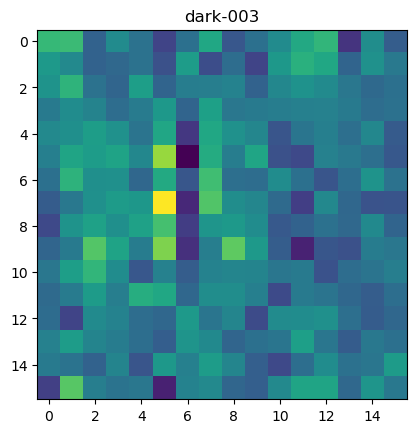

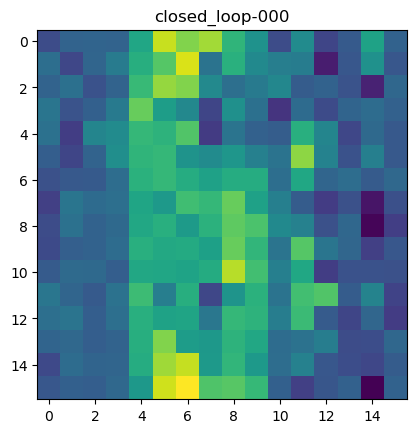

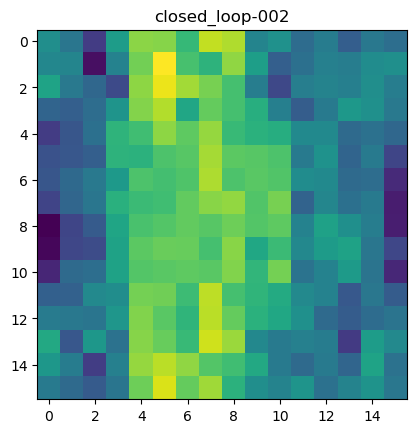

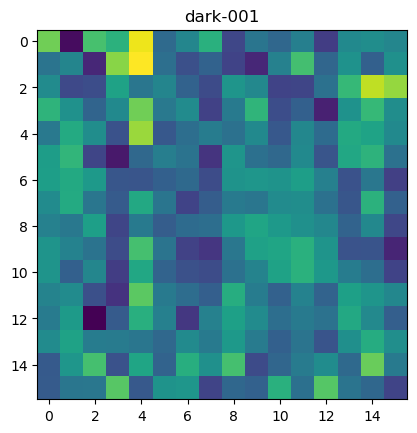

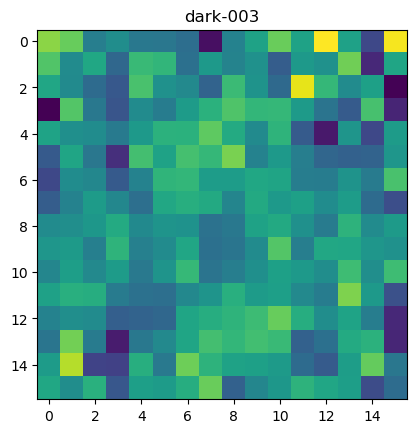

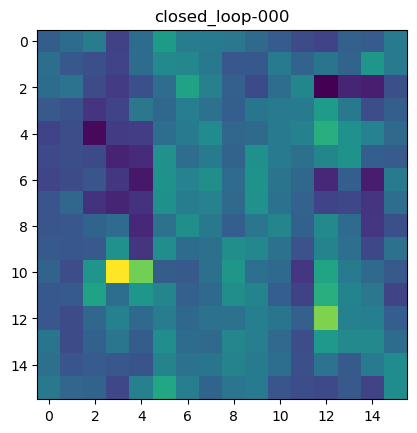

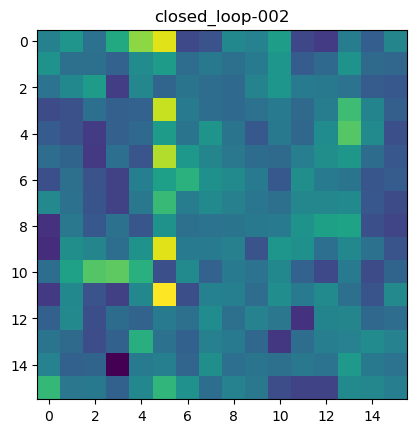

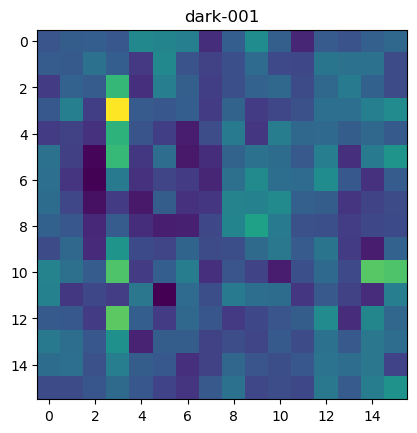

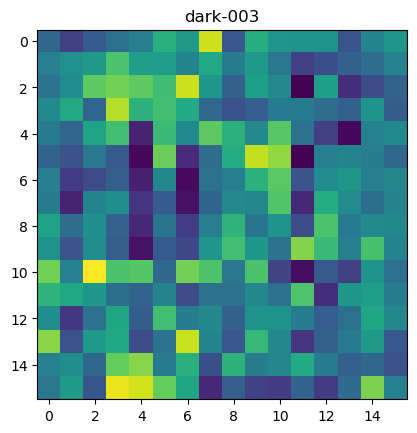

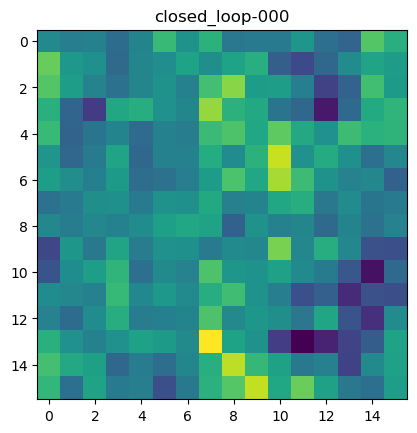

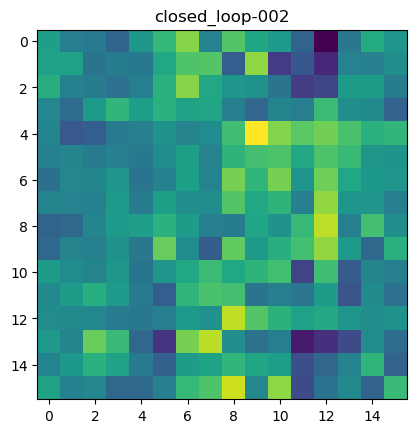

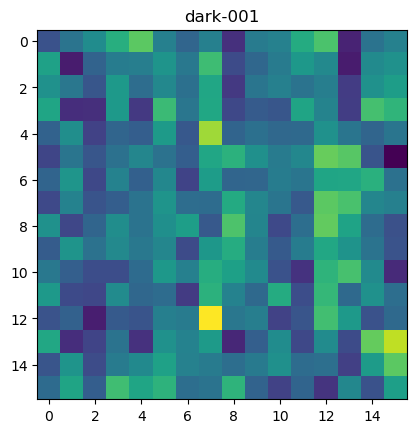

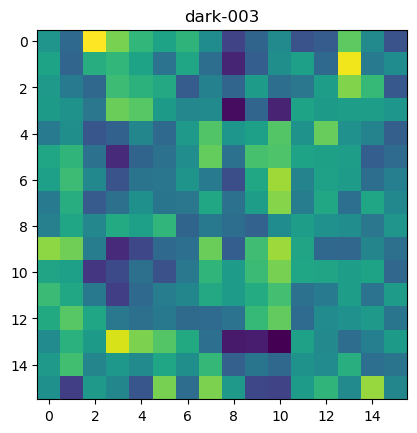

In [3]:
si_df = {'fly_id': [],
           'cl': [],
           'mi': []}



for _,row in sess_df.iterrows():
    if (row['usable']==1) and (row['terminals_only']==1):
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        dff = pp.timeseries['rois_z'][0,:,:]-1
        
        dff_dm = dff - dff.mean(axis=-1, keepdims=True)
        dff_dm -= np.amin(dff,axis=0, keepdims=True)
        
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        bin_edges = np.linspace(-np.pi, np.pi, num=17)
        heading_dig = np.digitize(heading,bin_edges)
        heading_count = np.bincount(heading_dig)
        heading_occ = heading_count/heading_count.sum()
        heading_occ = heading_occ[np.newaxis,:]

        dff_head_bin = np.zeros((dff.shape[0],heading_occ.shape[1]))
        for b in range(1,heading_occ.shape[1]):
            dff_head_bin[:,b] = dff_dm[:, heading_dig==b].mean(axis=-1)
            
        fig, ax= plt.subplots()
        ax.imshow(dff_head_bin[:,1:])
        ax.set_title(row['sess'])

        dff_head_bin = dff_head_bin/(dff_head_bin.mean(axis=-1,keepdims=True)+1E-3)
        SI = np.sum((dff_head_bin[:,1:]*heading_occ[:,1:])*np.log2(dff_head_bin[:,1:]), axis=1)
       
        si_df['fly_id'].append(row['fly_id'])
        si_df['cl'].append(row['closed_loop'])
        si_df['mi'].append(SI.mean())
si_df = pd.DataFrame.from_dict(si_df)




In [4]:
fly_ids = si_df['fly_id'].unique()

fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (si_df['fly_id']==fly)*(si_df['cl']==1)
    cl = si_df['mi'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (si_df['fly_id']==fly)*(si_df['cl']==0)
    dark = si_df['mi'].loc[mask].mean()
    fly_avgs[r,1] = dark
    


20.0 0.4921875


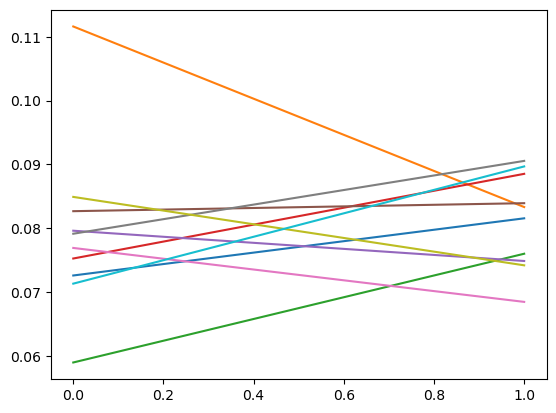

In [5]:
fig,ax = plt.subplots()
_ = ax.plot(fly_avgs.T)

u, p = sp.stats.wilcoxon(fly_avgs[:,0], fly_avgs[:,1])
print(u,p)

In [3]:
dark_v, cl_v = [], []

for _,row in sess_df.iterrows():
    if (row['usable']==1) and (row['terminals_only']==1):
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(pp.timeseries['rois_z'][0,:,:]-1, 1, axis=-1),.7,axis=1, mode='wrap')
        # dff = pp.timeseries['rois_z'][0,:,:]-1
        
        
        # dff_dm = (dff-np.amin(dff,axis=0,keepdims=True))/dff.sum(axis=0)
        
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        
        x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
        
        mask = np.abs(heading)>1.5
       
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        if row['closed_loop']==1:
            cl_v.append(sp.stats.circvar(offset[mask]+np.pi))
            # cl_v.append(np.abs(np.exp(1j*offset).mean()))
        else:
            dark_v.append(sp.stats.circvar(offset[mask]+np.pi))
            # dark_v.append(np.abs(np.exp(1j*offset).mean()))


cl_v = np.array(cl_v)
dark_v = np.array(dark_v)

152.0 0.05648519182783552


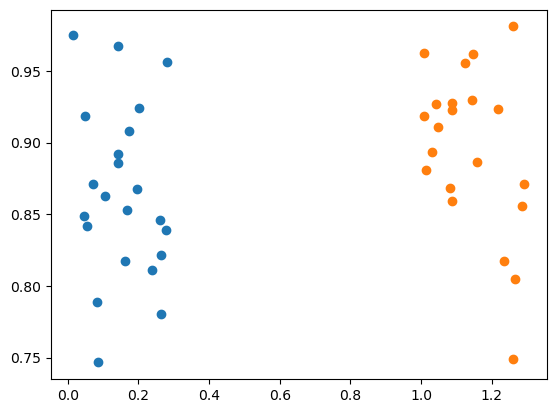

In [4]:
rng = np.random.default_rng()
fig, ax = plt.subplots()
ax.scatter(.3*rng.random(size=cl_v.shape), cl_v)
ax.scatter(1+.3*rng.random(size=dark_v.shape), dark_v)

u, p = sp.stats.mannwhitneyu(cl_v, dark_v)
print(u,p)


In [172]:
corr_df = {'fly_id': [],
           'cl': [],
           'corr': []}

dark_v, cl_v = [], []

for _,row in sess_df.iterrows():
    if (row['usable']==1) and (row['terminals_only']==1):
    # if row['usable']==1:
        # print(row)
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        
        # dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(1-pp.timeseries['rois_z'][0,:,:], 2, axis=-1),.7,axis=0, mode='wrap')
        # dff = sp.ndimage.gaussian_filter1d(1-pp.timeseries['rois_z'][0,:,:], .5, axis=0, mode='wrap')
        dff = 1-pp.timeseries['rois_z'][0,:,:]
        
        
        
        
        
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        
        
        x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
       
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
        
        heading_bins = np.linspace(-np.pi, np.pi, num=17)
        heading_dig = np.digitize(heading, heading_bins)-1
        

        
        offset_var = 0
        d = 0
        for b in range(16):
            if np.abs(heading_bins[b] )>1:
                mask = heading_dig==b
                offset_var += sp.stats.circvar(offset[mask])
                d+=1
        offset_var /= d
        
        
        corr_df['fly_id'].append(row['fly_id'])
        corr_df['cl'].append(row['closed_loop'])
        corr_df['corr'].append(offset_var)
corr_df = pd.DataFrame.from_dict(corr_df)



In [173]:
fly_ids = corr_df['fly_id'].unique()

fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (corr_df['fly_id']==fly)*(corr_df['cl']==1)
    cl = corr_df['corr'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (corr_df['fly_id']==fly)*(corr_df['cl']==0)
    # print(fly, corr_df['corr'].loc[mask])
    dark = corr_df['corr'].loc[mask].mean()
    fly_avgs[r,1] = dark

# print(fly_avgs)
# fly_avgs = np.arctanh(fly_avgs)
# fly_avgs = fly_avgs[fly_avgs[:,0]>0,:]

0.0 0.00048828125


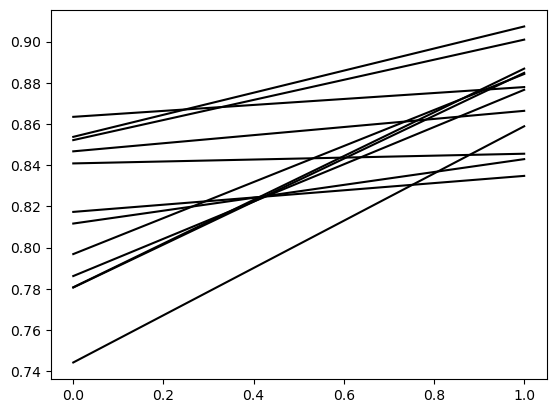

In [174]:
fig,ax = plt.subplots()
_ = ax.plot(fly_avgs.T, color='black')
# print(fly_avgs)
# t,p = sp.stats.ttest_1samp(fly_avgs[:,0], 0)
# print(t,p)

# t,p = sp.stats.ttest_1samp(fly_avgs[:,1], 0)
# print(t,p)

u, p = sp.stats.wilcoxon(fly_avgs[:,0],fly_avgs[:,1])
print(u,p)

# print(fly_avgs[:,0]-fly_avgs[:,1])

In [175]:
print(len(fly_ids))

12


0.0 0.00048828125


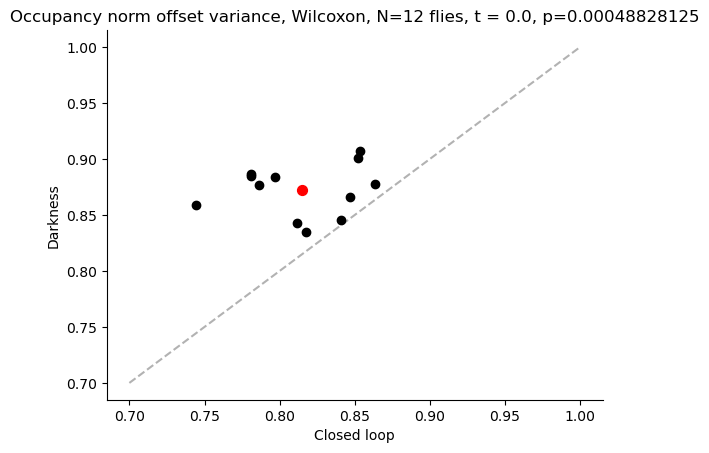

In [176]:
fig, ax= plt.subplots()
ax.scatter(fly_avgs[:,0], fly_avgs[:,1], color = 'black')
ax.plot([0.7,1],[0.7,1], 'k--',zorder= -1 , alpha=.3)


u, p = sp.stats.wilcoxon(fly_avgs[:,0], fly_avgs[:,1])
print(u,p)
com = fly_avgs.mean(axis=0)
ax.scatter(com[0], com[1], s=50, color='red')
ax.set_title(f'Occupancy norm offset variance, Wilcoxon, N={len(fly_ids)} flies, t = {u}, p={p}')
ax.set_xlabel('Closed loop')
ax.set_ylabel('Darkness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [207]:
import sklearn 
from sklearn import svm 


clsf_df = {'fly_id': [],
           'cl': [],
           'acc': []}

for _,row in sess_df.iterrows():
    if (row['usable']==1) and (row['terminals_only']==1):
    # if row['usable']==1:
        # print(row)
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
       
        dff = 1-pp.timeseries['rois_z'][0,:,:] 
        dff_dm = dff-dff.mean(axis=0,keepdims=True)
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        
        heading_bins = np.linspace(-np.pi, np.pi, num=9)
        heading_dig = np.digitize(heading, heading_bins)-1
        
        mask = np.abs(heading)>1
        
        # svc = svm.SVC(class_weight='balanced')
        svc = svm.SVC()
        score = sklearn.model_selection.cross_val_score(svc, dff[:,mask].T, heading_dig[mask], cv = 10, n_jobs=-1)
        clsf_df['fly_id'].append(row['fly_id'])
        clsf_df['cl'].append(row['closed_loop'])
        clsf_df['acc'].append(score.mean())
clsf_df = pd.DataFrame.from_dict(clsf_df)
        

In [208]:
(np.abs(heading_bins)>1.5).sum()

6

In [209]:
fly_ids = clsf_df['fly_id'].unique()

fly_avgs = np.zeros((len(fly_ids),2))
for r, fly in enumerate(fly_ids):
    
    mask = (clsf_df['fly_id']==fly)*(clsf_df['cl']==1)
    cl = clsf_df['acc'].loc[mask].mean()
    fly_avgs[r,0]=cl
    
    mask = (clsf_df['fly_id']==fly)*(clsf_df['cl']==0)
    dark = clsf_df['acc'].loc[mask].mean()
    fly_avgs[r,1] = dark

0.0 0.00048828125


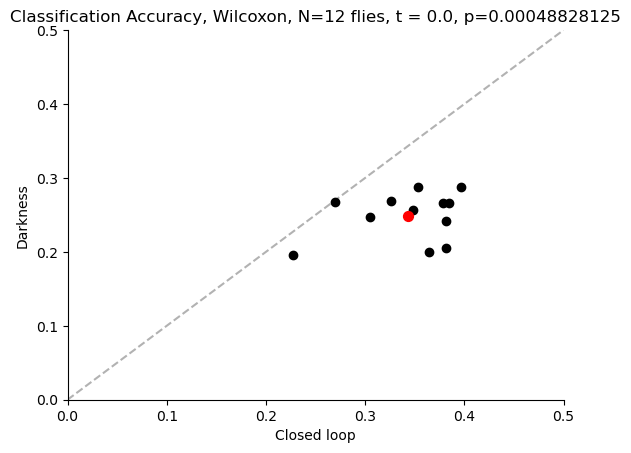

In [210]:
fig, ax= plt.subplots()
ax.scatter(fly_avgs[:,0], fly_avgs[:,1], color = 'black')
ax.plot([0,.5],[0,.5], 'k--',zorder= -1 , alpha=.3)
# ax.fill_between([1/6,.5],[1/6, 1/6], color='black', alpha=.4, edgecolor=None)
# ax.fill_betweenx([0,.5],[1/6, 1/6], color='black', alpha=.4, edgecolor=None)
ax.set_xlim([0,.5])
ax.set_ylim([0,.5])
# ax.plot([0,.4],[1/12, 1/12], 'k--')


u, p = sp.stats.wilcoxon(fly_avgs[:,0], fly_avgs[:,1])
print(u,p)
com = fly_avgs.mean(axis=0)
ax.scatter(com[0], com[1], s=50, color='red')
ax.set_title(f'Classification Accuracy, Wilcoxon, N={len(fly_ids)} flies, t = {u}, p={p}')
ax.set_xlabel('Closed loop')
ax.set_ylabel('Darkness')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [4]:
clsf_df = {'fly_id': [],
           'cl': [],
           'mu': []}

for _,row in sess_df.iterrows():
    if (row['usable']==1) and (row['terminals_only']==1):
        outdir = pathlib.PurePath( basedir / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)

        dff = 1-pp.timeseries['rois_z'][0,:,:] 
        dff_dm = dff-dff.mean(axis=0,keepdims=True)
        heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
        mask = np.abs(heading)>1

        heading_bins = np.linspace(-np.pi, np.pi, num=17)
        heading_dig = np.digitize(heading, heading_bins)-1

        dff_aligned = np.zeros_like(dff)
        d = 0
        for t in range(16):
            data = dff_dm[:,t]

            dff_aligned[:,t] = np.roll(data,-heading_dig[t])

        dff_aligned_mu = sp.stats.zscore(dff_aligned, axis=0)
        dff_aligned_mu = dff_aligned[:,mask].mean(axis=-1)
        clsf_df['fly_id'].append(row['fly_id'])
        clsf_df['cl'].append(row['closed_loop'])
        clsf_df['mu'].append(np.roll(dff_aligned_mu, -np.argmax(dff_aligned_mu)))
clsf_df = pd.DataFrame.from_dict(clsf_df)

In [5]:
fly_ids = clsf_df['fly_id'].unique()

fly_avgs = np.zeros((len(fly_ids),16,2))
for r, fly in enumerate(fly_ids):
    
    mask = (clsf_df['fly_id']==fly)*(clsf_df['cl']==1)
    cl = clsf_df['mu'].loc[mask]
    cl = np.array([row for row in cl])
    print(cl.shape)
    fly_avgs[r,:,0]=cl.mean(axis=0)
    
    mask = (clsf_df['fly_id']==fly)*(clsf_df['cl']==0)
    cl = clsf_df['mu'].loc[mask]
    cl = np.array([row for row in cl])
    print(cl.shape)
    fly_avgs[r,:,1]=cl.mean(axis=0)

(2, 16)
(1, 16)
(1, 16)
(1, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(2, 16)
(1, 16)
(1, 16)


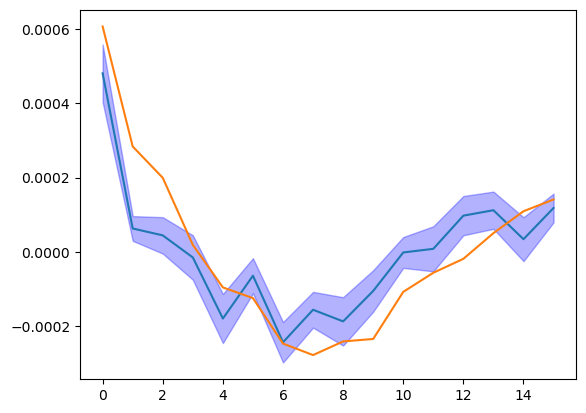

In [7]:
fig, ax = plt.subplots()
cl = fly_avgs[:,:,0]
ax.plot(cl.mean(axis=0))
x = np.arange(16)
mu, sem = cl.mean(axis=0), sp.stats.sem(cl, axis=0)
ax.fill_between(x, mu-sem, mu+sem, color='blue', alpha=.3)

dark = fly_avgs[:,:,1]

ax.plot(dark.mean(axis=0))


[0.09083286 0.09003418 0.08863243 0.0879523  0.08898124 0.09092574
 0.09275436 0.09062503 0.09352417 0.08998862 0.09102862 0.08964129
 0.09092245 0.09074258 0.08850238 0.08957199]


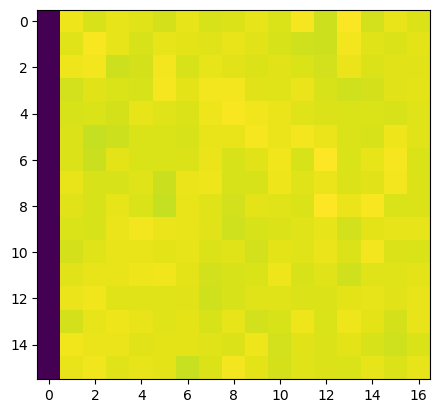

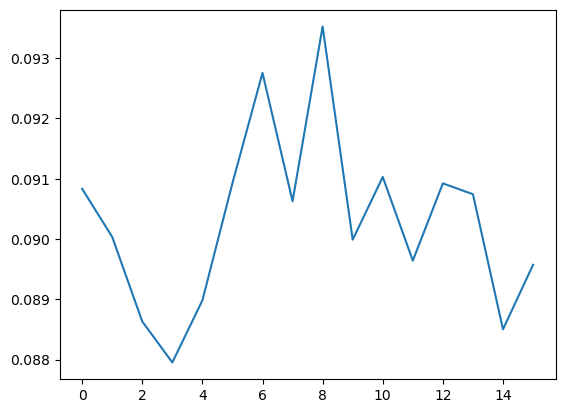

In [119]:
heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
bin_edges = np.linspace(-np.pi, np.pi, num=17)
heading_dig = np.digitize(heading,bin_edges)
heading_count = np.bincount(heading_dig)
heading_occ = heading_count/heading_count.sum()
heading_occ = heading_occ[np.newaxis,:]

dff_head_bin = np.zeros((dff.shape[0],heading_occ.shape[1]))
for b in range(1,heading_occ.shape[1]):
    dff_head_bin[:,b] = dff_dm[:, heading_dig==b].mean(axis=-1)
    
dff_head_bin = dff_head_bin/(dff_head_bin.mean(axis=-1,keepdims=True)+1E-3)
SI = np.sum((dff_head_bin[:,1:]*heading_occ[:,1:])*np.log2(dff_head_bin[:,1:]), axis=1)
print(SI)

fig, ax = plt.subplots()
ax.imshow(dff_head_bin)

fig,ax = plt.subplots()
ax.plot(SI)